<a href="https://colab.research.google.com/github/vishalrk1/pytorch/blob/main/AlexNet_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

import torchvision
from torchvision import transforms, datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet, self).__init__()

    self.Conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1)
    self.Conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
    self.Conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
    self.Conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
    self.Conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)

    self.Linear1 = nn.Linear(6400, 4096)
    self.Linear2 = nn.Linear(4096, 512)
    self.Linear3 = nn.Linear(512, 2)

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.5)

    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

    self.flatten = nn.Flatten()

  def forward(self, x):
    x = self.Conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.Conv2(x)
    x = self.maxpool(x)

    x = self.Conv3(x)
    x = self.Conv4(x)
    x = self.Conv5(x)
    x = self.maxpool(x)

    x = self.flatten(x)

    x = self.Linear1(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.Linear2(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.Linear3(x)
    return x

In [ ]:
model = AlexNet()
model.to(device)

AlexNet(
  (Conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (Conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Linear1): Linear(in_features=6400, out_features=4096, bias=True)
  (Linear2): Linear(in_features=4096, out_features=512, bias=True)
  (Linear3): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  --                        --
├─Conv2d: 1-1                            [1, 96, 54, 54]           34,944
├─ReLU: 1-2                              [1, 96, 54, 54]           --
├─MaxPool2d: 1-3                         [1, 96, 26, 26]           --
├─Conv2d: 1-4                            [1, 256, 26, 26]          614,656
├─MaxPool2d: 1-5                         [1, 256, 12, 12]          --
├─Conv2d: 1-6                            [1, 384, 12, 12]          885,120
├─Conv2d: 1-7                            [1, 384, 12, 12]          1,327,488
├─Conv2d: 1-8                            [1, 256, 12, 12]          884,992
├─MaxPool2d: 1-9                         [1, 256, 5, 5]            --
├─Flatten: 1-10                          [1, 6400]                 --
├─Linear: 1-11                           [1, 4096]                 26,218,496
├─ReLU: 1-12                             [1, 4096] 

In [ ]:
# Dataset 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

unzip_data('pizza_steak.zip')

--2022-01-18 06:20:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-18 06:20:05 (119 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2022-01-18 06:20:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.48, 172.253.63.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M

In [ ]:
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

In [ ]:
num_workers = 4

BATCH_SIZE = 32

valid_size = 0.2

normalize = transforms.Normalize(
    [0.485, 0.456, 0.406], 
    [0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
classes = train_data.classes
class_len = len(classes)

classes

['pizza', 'steak']

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Model training

epochs = 10

results = {
    'train_losses': [],
    'valid_losses': [],
    'train_acc': [],
    'valid_acc': [],
}

for epoch in range(epochs):
  print(f'<----- Epoch: {epoch+1} ----->')
  train_loss = 0
  valid_loss = 0

  train_acc = 0
  valid_acc = 0

  # training model on training dataset
  model.train()
  for images, labels in tqdm(train_dataloader, total=len(train_dataloader)):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    train_acc += (output_class == labels).sum().item()/len(output)

  # evaluating model on validation dataset
  model.eval()
  for images, labels in tqdm(valid_dataloader, total=len(valid_dataloader)):
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    valid_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    valid_acc += (output_class == labels).sum().item()/len(output)

  # calculating losses
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(valid_dataloader)

  # calculating accuracy
  train_acc = train_acc / len(train_dataloader)
  valid_acc = valid_acc / len(valid_dataloader)

  # storing losses and accuracy
  results['train_losses'].append(train_loss)
  results['valid_losses'].append(valid_loss)
  results['train_acc'].append(train_acc)
  results['valid_acc'].append(valid_acc)

  print('Training Loss: {:.6f} \tTraining Accuracy: {:.2f}'.format(train_loss, train_acc))
  print('Validation Loss: {:.6f} \tValidation Accuracy: {:.2f}'.format(valid_loss, valid_acc))

<----- Epoch: 1 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.541136 	Training Accuracy: 0.72
Validation Loss: 0.467134 	Validation Accuracy: 0.78
<----- Epoch: 2 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.450496 	Training Accuracy: 0.80
Validation Loss: 0.411763 	Validation Accuracy: 0.81
<----- Epoch: 3 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.445372 	Training Accuracy: 0.80
Validation Loss: 0.384523 	Validation Accuracy: 0.84
<----- Epoch: 4 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.400798 	Training Accuracy: 0.83
Validation Loss: 0.462258 	Validation Accuracy: 0.81
<----- Epoch: 5 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.396216 	Training Accuracy: 0.83
Validation Loss: 0.405289 	Validation Accuracy: 0.81
<----- Epoch: 6 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.376335 	Training Accuracy: 0.83
Validation Loss: 0.408570 	Validation Accuracy: 0.81
<----- Epoch: 7 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.355569 	Training Accuracy: 0.85
Validation Loss: 0.359468 	Validation Accuracy: 0.87
<----- Epoch: 8 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.369845 	Training Accuracy: 0.83
Validation Loss: 0.413708 	Validation Accuracy: 0.83
<----- Epoch: 9 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.343310 	Training Accuracy: 0.86
Validation Loss: 0.439626 	Validation Accuracy: 0.82
<----- Epoch: 10 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.302510 	Training Accuracy: 0.88
Validation Loss: 0.344237 	Validation Accuracy: 0.85


In [ ]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  #plt.show()

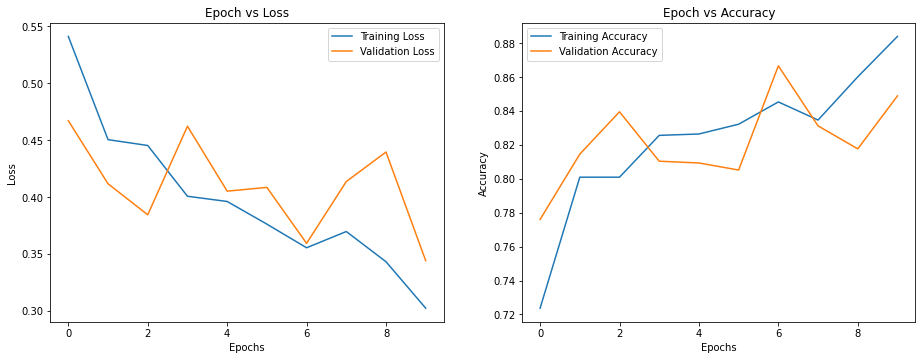

In [ ]:
plot_loss_accuracy(results['train_losses'], results['train_acc'], results['valid_losses'], results['valid_acc'])

In [ ]:
# calculating accuracy for test dataset
# function to calculate accuracy 
def calculate_acc(model, loader):
  n_correct = 0
  n_total = 0

  for inputs, targets in loader:
    # moving data to gpu
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Getting prediction
    # torch max returns both max and argmax
    _, preds = torch.max(outputs, 1)

    # Updating counts
    n_correct += (preds == targets).sum().item()
    n_total += targets.shape[0] 

  acc = n_correct / n_total
  return acc

In [ ]:
calculate_acc(model, train_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8941666666666667